# Building Simple Neural Networks

In this section you will:

* Import the MNIST dataset from Keras.
* Format the data so it can be used by a Sequential model with Dense layers.
* Split the dataset into training and test sections data.
* Build a simple neural network using Keras Sequential model and Dense layers.
* Train that model.
* Evaluate the performance of that model.

While we are accomplishing these tasks, we will also stop to discuss important concepts:

* Splitting data into test and training sets.
* Training rounds, batch size, and epochs.
* Validation data vs test data.
* Examining results.

## Importing and Formatting the Data

Keras has several built-in datasets that are already well formatted and properly cleaned. These datasets are an invaluable learning resource. Collecting and processing datasets is a serious undertaking, and deep learning tactics perform poorly without large high quality datasets. We will be leveraging the [Keras built in datasets](https://keras.io/datasets/) extensively, and you may wish to explore them further on your own.

In this exercise, we will be focused on the MNIST dataset, which is a set of 70,000 images of handwritten digits each labeled with the value of the written digit. Additionally, the images have been split into training and test sets.

In [1]:
# For drawing the MNIST digits as well as plots to help us evaluate performance we
# will make extensive use of matplotlib
from matplotlib import pyplot as plt

# All of the Keras datasets are in keras.datasets
from tensorflow.keras.datasets import mnist

# Keras has already split the data into training and test data
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()

# Training images is a list of 60,000 2D lists.
# Each 2D list is 28 by 28—the size of the MNIST pixel data.
# Each item in the 2D array is an integer from 0 to 255 representing its grayscale
# intensity where 0 means white, 255 means black.
print(len(training_images), training_images[0].shape)

# training_labels are a value between 0 and 9 indicating which digit is represented.
# The first item in the training data is a 5
print(len(training_labels), training_labels[0])


60000 (28, 28)
60000 5


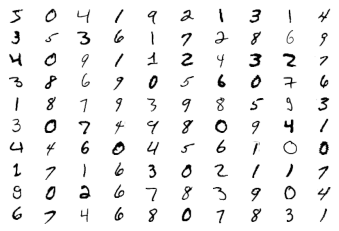

In [2]:
# Lets visualize the first 100 images from the dataset
for i in range(100):
    ax = plt.subplot(10, 10, i+1)
    ax.axis('off')
    plt.imshow(training_images[i], cmap='Greys')


## Problems With This Data

There are (at least) two problems with this data as it is currently formatted, what do you think they are?

1. The input data is formatted as a 2D array, but our deep neural network needs to data as a 1D vector.
  * This is because of how deep neural networks are constructed, it is simply not possible to send anything but a vector as input.
  * These vectors can be/represent anything, but from the computer's perspective they must be a 1D vector.
2. Our labels are numbers, but we're not performing regression. We need to use a 1-hot vector encoding for our labels.
  * This is important because if we use the number values we would be training our network to think of these values as continuous.
  * If the digit is supposed to be a 2, guessing 1 and guessing 9 are both equally wrong.
  * Training the network with numbers would imply that a prediction of 1 would be "less wrong" than a prediction of 9, when in fact both are equally wrong. 

### Fixing the data format

Luckily, this is a common problem and we can use two methods to fix the data: `numpy.reshape` and `keras.utils.to_categorical`. This is nessesary because of how deep neural networks process data, there is no way to send 2D data to a `Sequential` model made of `Dense` layers.

In [3]:
from tensorflow.keras.utils import to_categorical

# Preparing the dataset
# Setup train and test splits
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()


# 28 x 28 = 784, because that's the dimensions of the MNIST data.
image_size = 784

# Reshaping the training_images and test_images to lists of vectors with length 784
# instead of lists of 2D arrays. Same for the test_images
training_data = training_images.reshape(training_images.shape[0], image_size) 
test_data = test_images.reshape(test_images.shape[0], image_size)

# [
#     [1,2,3]
#     [4,5,6]
# ]

# => [1,2,3,4,5,6]

# Just showing the changes...
print("training data: ", training_images.shape, " ==> ", training_data.shape)
print("test data: ", test_images.shape, " ==> ", test_data.shape)

training data:  (60000, 28, 28)  ==>  (60000, 784)
test data:  (10000, 28, 28)  ==>  (10000, 784)


In [4]:
# Create 1-hot encoded vectors using to_categorical
num_classes = 10 # Because it's how many digits we have (0-9) 

# to_categorical takes a list of integers (our labels) and makes them into 1-hot vectors
training_labels = to_categorical(training_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

In [5]:
# Recall that before this transformation, training_labels[0] was the value 5. Look now:
print(training_labels[0])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


## Building a Deep Neural Network

Now that we've prepared our data, it's time to build a simple neural network. To start we'll make a deep network with 3 layers—the input layer, a single hidden layer, and the output layer. In a deep neural network all the layers are 1 dimensional. The input layer has to be the shape of our input data, meaning it must have 784 nodes. Similarly, the output layer must match our labels, meaning it must have 10 nodes. We can choose the number of nodes in our hidden layer, I've chosen 32 arbitrarally.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Sequential models are a series of layers applied linearly.
model = Sequential()

# The first layer must specify it's input_shape.
# This is how the first two layers are added, the input layer and the hidden layer.
model.add(Dense(units=32, activation='sigmoid', input_shape=(image_size,)))

# This is how the output layer gets added, the 'softmax' activation function ensures
# that the sum of the values in the output nodes is 1. Softmax is very
# common in classification networks. 
model.add(Dense(units=num_classes, activation='softmax'))

# This function provides useful text data for our network
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


## Compiling and Training a Model

Our model must be compiled and trained before it can make useful predictions. Models are trainined with the training data and training labels. During this process Keras will use an optimizer, loss function, metrics of our chosing to repeatedly make predictions and recieve corrections. The loss function is used to train the model, the metrics are only used for human evaluation of the model during and after training.

Training happens in a series of epochs which are divided into a series of rounds. Each round the network will recieve `batch_size` samples from the training data, make predictions, and recieve one correction based on the errors in those predictions. In a single epoch, the model will look at every item in the training set __exactly once__, which means individual data points are sampled from the training data without replacement during each round of each epoch.

During training, the training data itself will be broken into two parts according to the `validation_split` parameter. The proportion that you specify will be left out of the training process, and used to evaluate the accuracy of the model. This is done to preserve the test data, while still having a set of data left out in order to test against — and hopefully prevent — overfitting. At the end of each epoch, predictions will be made for all the items in the validation set, but those predictions won't adjust the weights in the model. Instead, if the accuracy of the predictions in the validation set stops improving then training will stop early, even if accuracy in the training set is improving. 

In [7]:
# sgd stands for stochastic gradient descent.
# categorical_crossentropy is a common loss function used for categorical classification.
# accuracy is the percent of predictions that were correct.
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])

# The network will make predictions for 128 flattened images per correction.
# It will make a prediction on each item in the training set 5 times (5 epochs)
# And 10% of the data will be used as validation data.
history = model.fit(training_data, training_labels, batch_size=128, epochs=5, verbose=True, validation_split=.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 1s 23us/sample - loss: 1.3004 - accuracy: 0.6599 - val_loss: 0.8499 - val_accuracy: 0.8328
Epoch 2/5
54000/54000 [==============================] - 1s 11us/sample - loss: 0.7825 - accuracy: 0.8300 - val_loss: 0.6217 - val_accuracy: 0.8803
Epoch 3/5
54000/54000 [==============================] - 1s 11us/sample - loss: 0.6256 - accuracy: 0.8633 - val_loss: 0.5193 - val_accuracy: 0.8980
Epoch 4/5
54000/54000 [==============================] - 1s 11us/sample - loss: 0.5424 - accuracy: 0.8778 - val_loss: 0.4621 - val_accuracy: 0.9082
Epoch 5/5
54000/54000 [==============================] - 1s 11us/sample - loss: 0.4903 - accuracy: 0.8864 - val_loss: 0.4099 - val_accuracy: 0.9105


## Micro Exercise: Build and Train Your First Neural Network

Using the training and test data we prepped above, build a neural network with at least 3 "hidden layers" and train it for 5 epochs. For now, continue to use the `'sgd'` optimizer and the `'cactegorical_cross_entropy'` loss function. You may use any `batch_size` you wish during training, and any number of `units` in your hidden layers (but note that very small `batch_sizes` and very large `units` will increase the time it takes to train.

In [ ]:
# Put your code here...

## Evaluating Our Model

Now that we've trained our model, we want to evaluate its performance. We're using the "test data" here although in a serious experiment, we would likely not have done nearly enough work to warrent the application of the test data. Instead, we would rely on the validation metrics as a proxy for our test results until we had models that we believe would perform well. 

Once we evaluate our model on the test data, any subsequent changes we make would be based on what we learned from the test data. Meaning, we would have functionally incorporated information from the test set into our training procedure which could bias and even invalidate the results of our research. In a non-research setting the real test might be more like putting this feature into production. 

Nevertheless, it is always wise to create a test set that is not used as an evaluative measure until the very end of an experimental lifecycle. That is, once you have a model that you believe __should__ generalize well to unseen data you should test it on the test data to test that hypothosis. If your model performs poorly on the test data, you'll have to reevaluate your model, training data, and procedure. 

10000/10000 [==============================] - 0s 21us/sample - loss: 0.4473 - accuracy: 0.8978


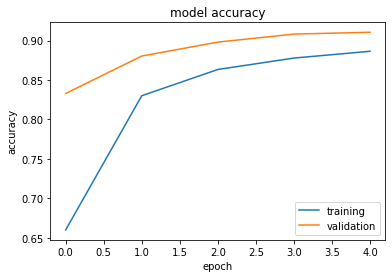

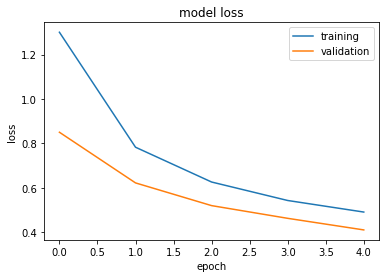

Test loss: 0.447
Test accuracy: 0.898


In [8]:
loss, accuracy = model.evaluate(test_data, test_labels, verbose=True)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')

plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')

plt.show()

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

## Discussion: How Did Our Networks Do? 

* Why do we only have one value for test loss and test accuracy, but a chart over time for training and validation loss and accuracy?
* Our model was more accurate on the validation data than it was on the training data. 
  * Is this okay? Why or why not?
  * What if our model had been more accurate on the training data than the validation data?
* Did our model get better during each epoch?
  * If not: why might that be the case?
  * If so: should we always expect this, where each epoch strictly improves training/validation accuracy/loss?

### Answers:


* Why do we only have one value for test loss and test accuracy, but a chart over time for training and validation loss and accuracy?
  * __Because we only evaluate the test data once at the very end, but we evaluate training and validation scores once per epoch.__
* Our model was more accurate on the validation data than it was on the training data. 
  * Is this okay? Why or why not?
    * __Yes, this is okay, and even good. When our validation scores are better than our training scores, it's a sign that we are probably not overfitting__
  * What if our model had been more accurate on the training data than the validation data?
    * __This would concern us, because it would suggest we are probably overfitting.__
* Did our model get better during each epoch?
  * If not: why might that be the case?
    * __Optimizers rely on the gradient to update our weights, but the 'function' we are optimizing (our neural network) is not a ground truth. A single batch, and even a complete epoch, may very well result in an adjustment that hurts overall performance.__
  * If so: should we always expect this, where each epoch strictly improves training/validation accuracy/loss?
    * __Not at all, see the above answer.__

## Look at Specific Results

Often, it can be illuminating to view specific results, both when the model is correct and when the model is wrong. Lets look at the images and our model's predictions for the first 16 samples in the test set.

In [9]:
from numpy import argmax

# Predicting once, then we can use these repeatedly in the next cell without recomputing the predictions.
predictions = model.predict(test_data)

# For pagination & style in second cell
page = 0
fontdict = {'color': 'black'}

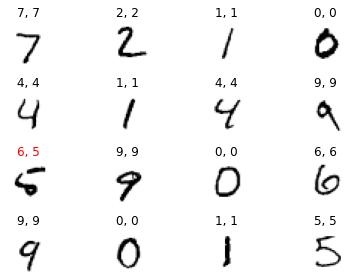

In [10]:
# Repeatedly running this cell will page through the predictions
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    ax.axis('off')
    plt.imshow(test_images[i + page], cmap='Greys')
    prediction = argmax(predictions[i + page])
    true_value = argmax(test_labels[i + page])

    fontdict['color'] = 'black' if prediction == true_value else 'red'
    plt.title("{}, {}".format(prediction, true_value), fontdict=fontdict)

page += 16
plt.tight_layout()
plt.show()